In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Imputación de nulos

In [5]:
# Revisión de valores nulos
print("Valores nulos por columna:")
print(data.isnull().sum())
print("\nPorcentaje de valores nulos por columna:")
print(data.isnull().sum()/len(data) * 100)

# Revisión de duplicados
duplicados = data.duplicated().sum()
print(f"\nNúmero de registros duplicados: {duplicados}")

# Revisión de tipos de datos
print("\nTipos de datos de las columnas:")
print(data.dtypes)

Valores nulos por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Porcentaje de valores nulos por columna:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Número de registros duplicados: 0

Tipos de datos de las columnas:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
# Poner la columna 'Age' mediante KNN imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data['Age'] = imputer.fit_transform(data[['Age', 'Pclass', 'Fare']])[:, 0]

# Poner la columna 'Embarked' con la moda
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Poner la columna 'Cabin' con "Unknown" 
data['Cabin'] = data['Cabin'].fillna("Unknown")

# Feature Engineering

In [7]:
import re

def extraer_titulo_robusto(nombre):
    """
    Función robusta para extraer títulos/gentilicios de nombres completos.
    
    Parámetros:
    nombre (str): Nombre completo de la persona
    
    Retorna:
    str: Título extraído y normalizado
    """
    if pd.isna(nombre) or not isinstance(nombre, str):
        return 'Unknown'
    
    # Diccionario de mapeo para normalizar títulos
    titulo_mapping = {
        # Títulos masculinos
        'Mr': 'Mr',
        'Master': 'Master',
        'Rev': 'Rev',
        'Dr': 'Dr',
        'Major': 'Military',
        'Col': 'Military',
        'Capt': 'Military',
        'Sir': 'Nobility',
        'Don': 'Nobility',
        'Jonkheer': 'Nobility',
        
        # Títulos femeninos
        'Mrs': 'Mrs',
        'Miss': 'Miss',
        'Ms': 'Miss',
        'Mme': 'Mrs',
        'Mlle': 'Miss',
        'Lady': 'Nobility',
        'Countess': 'Nobility',
        'Dona': 'Nobility',
        
        # Títulos profesionales
        'Prof': 'Dr',
        'Doctor': 'Dr',
        'Professor': 'Dr'
    }
    
    # Patrón regex para encontrar títulos
    # Busca palabras que terminan en punto o están seguidas de un espacio/punto
    patron = r'\b([A-Za-z]+\.?)\s'
    
    # Buscar todos los posibles títulos
    matches = re.findall(patron, nombre)
    
    for match in matches:
        # Limpiar el match (quitar puntos)
        titulo_limpio = match.replace('.', '')
        
        # Verificar si es un título conocido
        if titulo_limpio in titulo_mapping:
            return titulo_mapping[titulo_limpio]
        
        # Verificar variaciones comunes
        titulo_lower = titulo_limpio.lower()
        for key in titulo_mapping.keys():
            if titulo_lower == key.lower():
                return titulo_mapping[key]
    
    # Si no se encuentra un título específico, intentar con patrones más generales
    # Buscar palabras entre comas (formato: Apellido, Título. Nombre)
    if ',' in nombre:
        partes = nombre.split(',')
        if len(partes) >= 2:
            segunda_parte = partes[1].strip()
            # Buscar título en la segunda parte
            titulo_match = re.search(r'\b([A-Za-z]+)', segunda_parte)
            if titulo_match:
                titulo_encontrado = titulo_match.group(1)
                if titulo_encontrado in titulo_mapping:
                    return titulo_mapping[titulo_encontrado]
    
    # Como último recurso, categorizar por patrones de género
    nombre_lower = nombre.lower()
    if any(fem in nombre_lower for fem in ['miss', 'mrs', 'ms', 'lady', 'mme', 'mlle']):
        return 'Miss' if 'miss' in nombre_lower or 'mlle' in nombre_lower else 'Mrs'
    elif any(masc in nombre_lower for masc in ['mr', 'master', 'sir', 'don']):
        return 'Master' if 'master' in nombre_lower else 'Mr'
    
    return 'Unknown'

# Aplicar la función al dataset
data['Titulo'] = data['Name'].apply(extraer_titulo_robusto)

# Mostrar la distribución de títulos extraídos
print("Distribución de Títulos Extraídos:")
print("="*40)
print(data['Titulo'].value_counts())

# Mostrar algunos ejemplos
print("\nEjemplos de extracción:")
print("="*40)
ejemplos = data[['Name', 'Titulo']].head(10)
for idx, row in ejemplos.iterrows():
    print(f"Nombre: {row['Name']}")
    print(f"Título: {row['Titulo']}")
    print("-" * 50)

Distribución de Títulos Extraídos:
Titulo
Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Nobility      5
Military      5
Name: count, dtype: int64

Ejemplos de extracción:
Nombre: Braund, Mr. Owen Harris
Título: Mr
--------------------------------------------------
Nombre: Cumings, Mrs. John Bradley (Florence Briggs Thayer)
Título: Mrs
--------------------------------------------------
Nombre: Heikkinen, Miss. Laina
Título: Miss
--------------------------------------------------
Nombre: Futrelle, Mrs. Jacques Heath (Lily May Peel)
Título: Mrs
--------------------------------------------------
Nombre: Allen, Mr. William Henry
Título: Mr
--------------------------------------------------
Nombre: Moran, Mr. James
Título: Mr
--------------------------------------------------
Nombre: McCarthy, Mr. Timothy J
Título: Mr
--------------------------------------------------
Nombre: Palsson, Master. Gosta Leonard
Título: Master
---------------------

In [8]:
# Crear variable Family (suma de Parch y SibSp)
data['Family'] = data['Parch'] + data['SibSp']

# Crear variable IsAlone (1 si viajaba solo, 0 si no)
data['IsAlone'] = (data['Family'] == 0).astype(int)

# Mostrar información sobre las nuevas variables
print("Nueva variable 'Family' (Parch + SibSp):")
print("="*40)
print(data['Family'].value_counts().sort_index())
print(f"\nMedia de tamaño familiar: {data['Family'].mean():.2f}")
print(f"Máximo tamaño familiar: {data['Family'].max()}")

print("\n\nNueva variable 'IsAlone' (viajaba solo):")
print("="*40)
print(data['IsAlone'].value_counts())
print(f"\nPorcentaje de pasajeros que viajaban solos: {(data['IsAlone'].sum() / len(data) * 100):.2f}%")


Nueva variable 'Family' (Parch + SibSp):
Family
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64

Media de tamaño familiar: 0.90
Máximo tamaño familiar: 10


Nueva variable 'IsAlone' (viajaba solo):
IsAlone
1    537
0    354
Name: count, dtype: int64

Porcentaje de pasajeros que viajaban solos: 60.27%


# Análisis Univariado

## Cuantitativas

In [9]:
numeric_cols = ['Age', 'Fare']

In [10]:
from scipy.stats import skew, kurtosis, shapiro

def plot_numeric_distributions(data, numeric_cols):
    cols_per_row = 2
    n = len(numeric_cols)
    rows = -(-n // cols_per_row)

    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    for idx, col in enumerate(numeric_cols, 1):
        sk = skew(data[col].dropna())
        kt = kurtosis(data[col].dropna())
        _, p = shapiro(data[col].dropna())

        plt.subplot(rows, cols_per_row*2, idx*2-1)
        sns.histplot(data[col], kde=True, bins=20, color="skyblue")
        plt.title(f"{col}\nSkew: {sk:.2f}, Kurt: {kt:.2f}, p={p:.2g}")

        plt.subplot(rows, cols_per_row*2, idx*2)
        sns.boxplot(y=data[col], color="lightcoral", showmeans=True)
        plt.title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

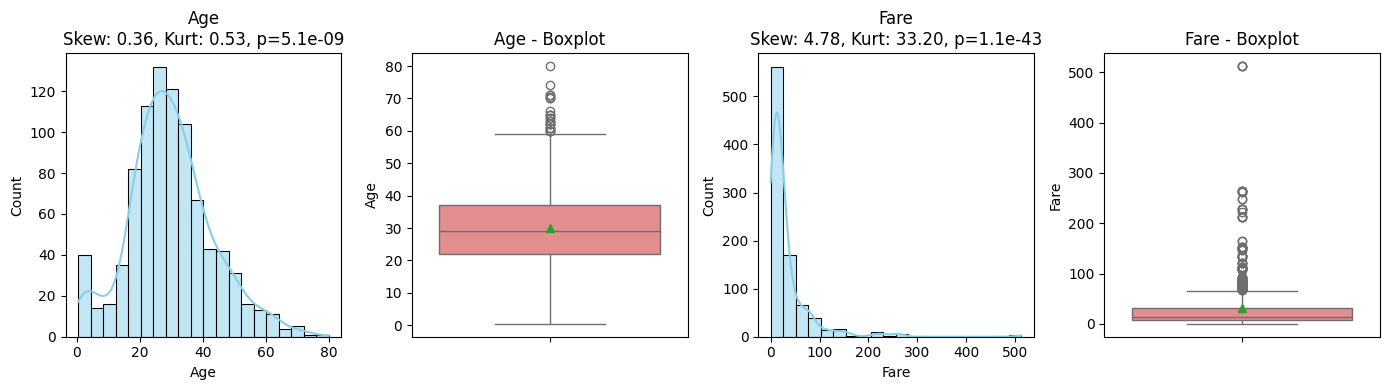

In [11]:
plot_numeric_distributions(data, numeric_cols)

## Cualitativas

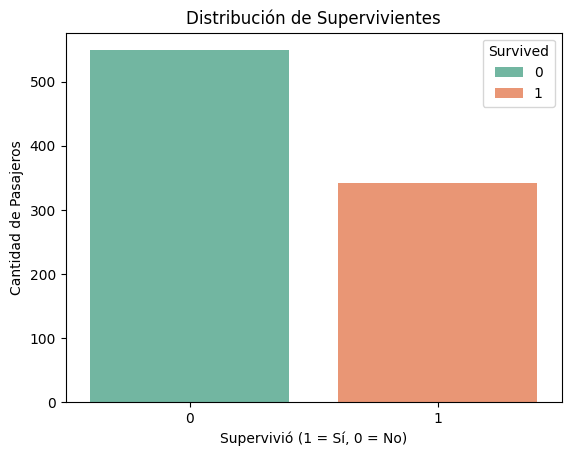

In [12]:
sns.countplot(data=data, x='Survived', hue='Survived', palette='Set2')
plt.title('Distribución de Supervivientes')
plt.xlabel('Supervivió (1 = Sí, 0 = No)')
plt.ylabel('Cantidad de Pasajeros')
plt.show()

In [13]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo,Family,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.2500,Unknown,S,Mr,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.2833,C85,C,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.1000,C123,S,Mrs,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.0500,Unknown,S,Mr,0,1
5,6,0,3,"Moran, Mr. James",male,22.684,0,0,330877,8.4583,Unknown,Q,Mr,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.8625,E46,S,Mr,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000,3,1,349909,21.0750,Unknown,S,Master,4,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000,0,2,347742,11.1333,Unknown,S,Mrs,2,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000,1,0,237736,30.0708,Unknown,C,Mrs,1,0


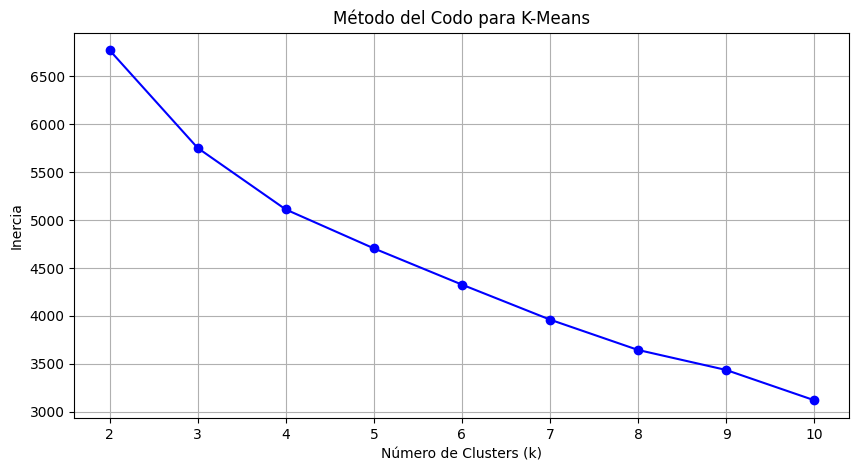


RESULTADOS DEL CLUSTERING (K=3)

Distribución de pasajeros por cluster:
Cluster
0    278
1    511
2    102
Name: count, dtype: int64


Características promedio por cluster:
         Survived  Pclass    Age   Fare  Family  IsAlone
Cluster                                                 
0            0.56    1.90  32.00  58.50    1.30     0.09
1            0.27    2.47  31.92  14.44    0.00     1.00
2            0.45    2.61  14.08  49.54    4.35     0.00


Distribución de Sexo por cluster:
Sex      female  male
Cluster              
0          0.58  0.42
1          0.20  0.80
2          0.49  0.51


Tasa de supervivencia por cluster:
         mean  count
Cluster             
0        0.56    278
1        0.27    511
2        0.45    102


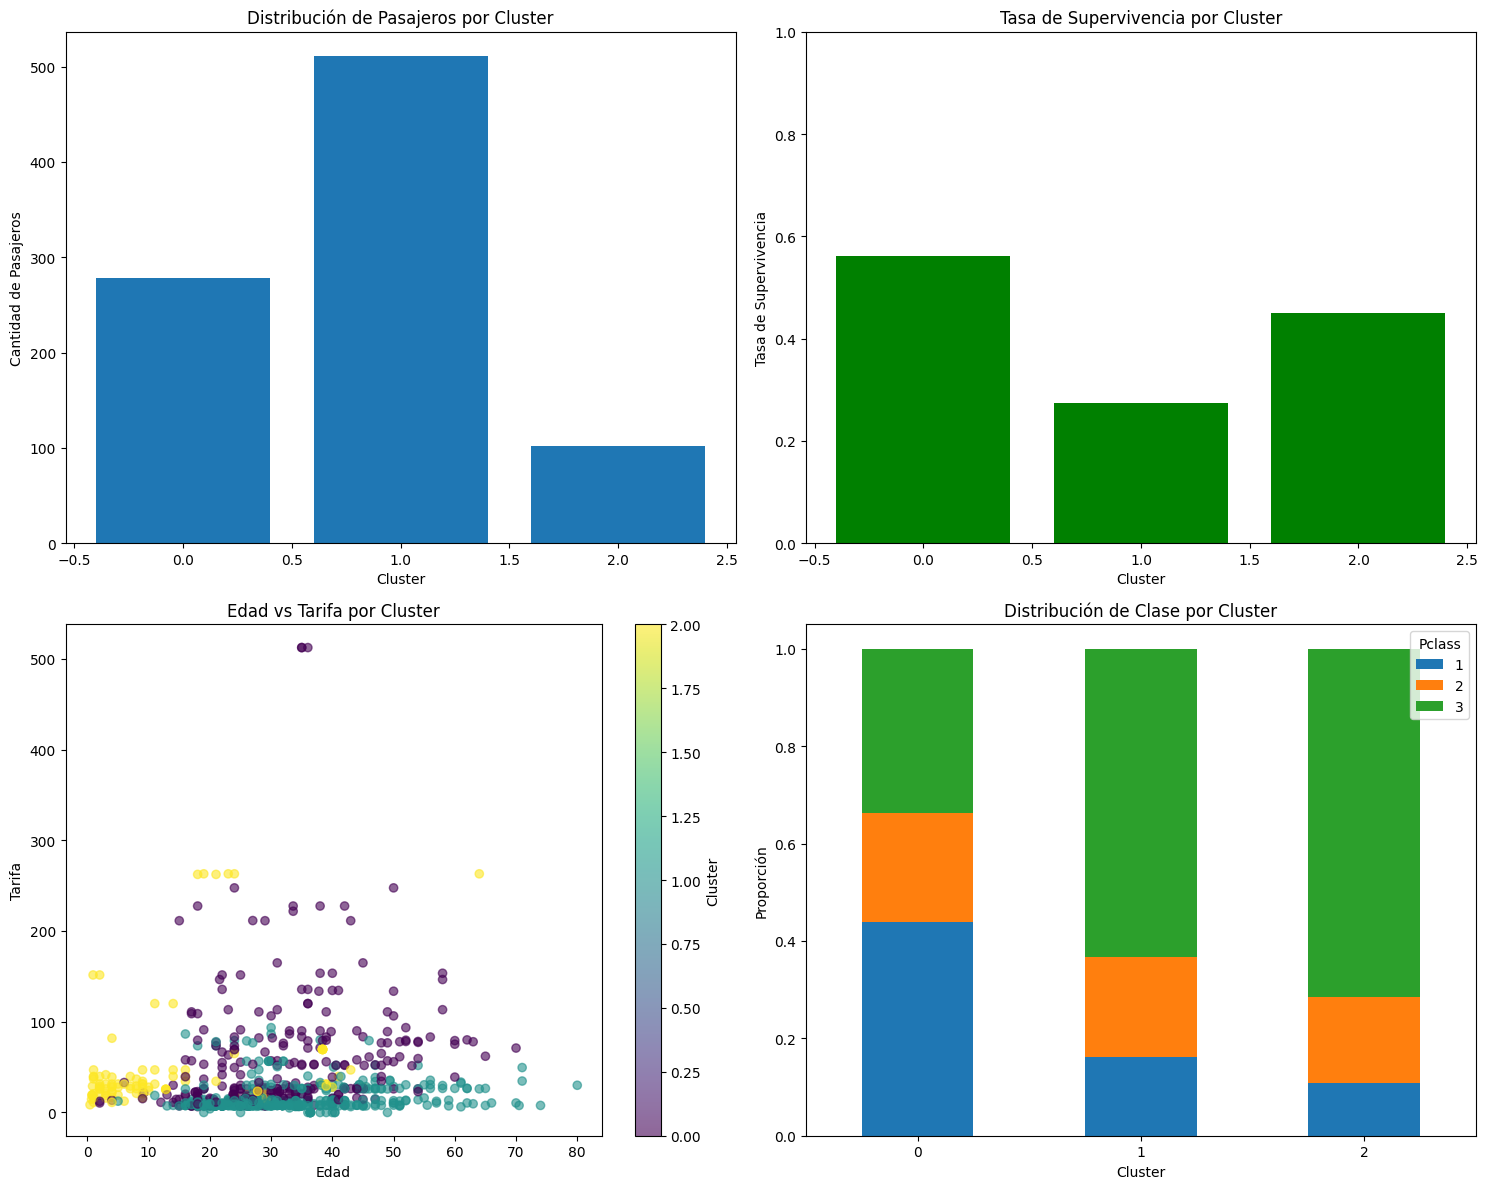


✓ Clustering completado. Columna 'Cluster' agregada al dataset 'data'


In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar datos para clustering
df_cluster = data.copy()

# Seleccionar features relevantes para clustering
# Excluir: PassengerId, Name, Ticket, Cabin (alta cardinalidad), Survived (target)
features_numericas = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family', 'IsAlone']
features_categoricas = ['Sex', 'Embarked', 'Titulo']

# Codificar variables categóricas
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
le_titulo = LabelEncoder()

df_cluster['Sex_encoded'] = le_sex.fit_transform(df_cluster['Sex'])
df_cluster['Embarked_encoded'] = le_embarked.fit_transform(df_cluster['Embarked'])
df_cluster['Titulo_encoded'] = le_titulo.fit_transform(df_cluster['Titulo'])

# Features finales para clustering
features_clustering = features_numericas + ['Sex_encoded', 'Embarked_encoded', 'Titulo_encoded']
X = df_cluster[features_clustering]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Método del codo para encontrar k óptimo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualizar método del codo
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.grid(True)
plt.show()

# Aplicar K-means con k=3 (ajusta según el método del codo)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# Agregar cluster al dataset original
data['Cluster'] = df_cluster['Cluster']

# Análisis de clusters
print(f"\n{'='*60}")
print(f"RESULTADOS DEL CLUSTERING (K={k_optimo})")
print(f"{'='*60}\n")

print("Distribución de pasajeros por cluster:")
print(data['Cluster'].value_counts().sort_index())

print("\n\nCaracterísticas promedio por cluster:")
caracteristicas = ['Survived', 'Pclass', 'Age', 'Fare', 'Family', 'IsAlone']
cluster_stats = data.groupby('Cluster')[caracteristicas].mean()
print(cluster_stats.round(2))

print("\n\nDistribución de Sexo por cluster:")
print(pd.crosstab(data['Cluster'], data['Sex'], normalize='index').round(2))

print("\n\nTasa de supervivencia por cluster:")
print(data.groupby('Cluster')['Survived'].agg(['mean', 'count']).round(2))

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de clusters
axes[0, 0].bar(data['Cluster'].value_counts().sort_index().index, 
               data['Cluster'].value_counts().sort_index().values)
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Cantidad de Pasajeros')
axes[0, 0].set_title('Distribución de Pasajeros por Cluster')

# 2. Supervivencia por cluster  
survival_by_cluster = data.groupby('Cluster')['Survived'].mean()
axes[0, 1].bar(survival_by_cluster.index, survival_by_cluster.values, color='green')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Tasa de Supervivencia')
axes[0, 1].set_title('Tasa de Supervivencia por Cluster')
axes[0, 1].set_ylim([0, 1])

# 3. Edad vs Fare coloreado por cluster
scatter = axes[1, 0].scatter(data['Age'], data['Fare'], c=data['Cluster'], 
                             cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel('Edad')
axes[1, 0].set_ylabel('Tarifa')
axes[1, 0].set_title('Edad vs Tarifa por Cluster')
plt.colorbar(scatter, ax=axes[1, 0], label='Cluster')

# 4. Clase vs Cluster
cluster_class = pd.crosstab(data['Cluster'], data['Pclass'], normalize='index')
cluster_class.plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Proporción')
axes[1, 1].set_title('Distribución de Clase por Cluster')
axes[1, 1].legend(title='Pclass')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f"\n✓ Clustering completado. Columna 'Cluster' agregada al dataset 'data'")

## Análisis Detallado de Clusters - Insights Adicionales

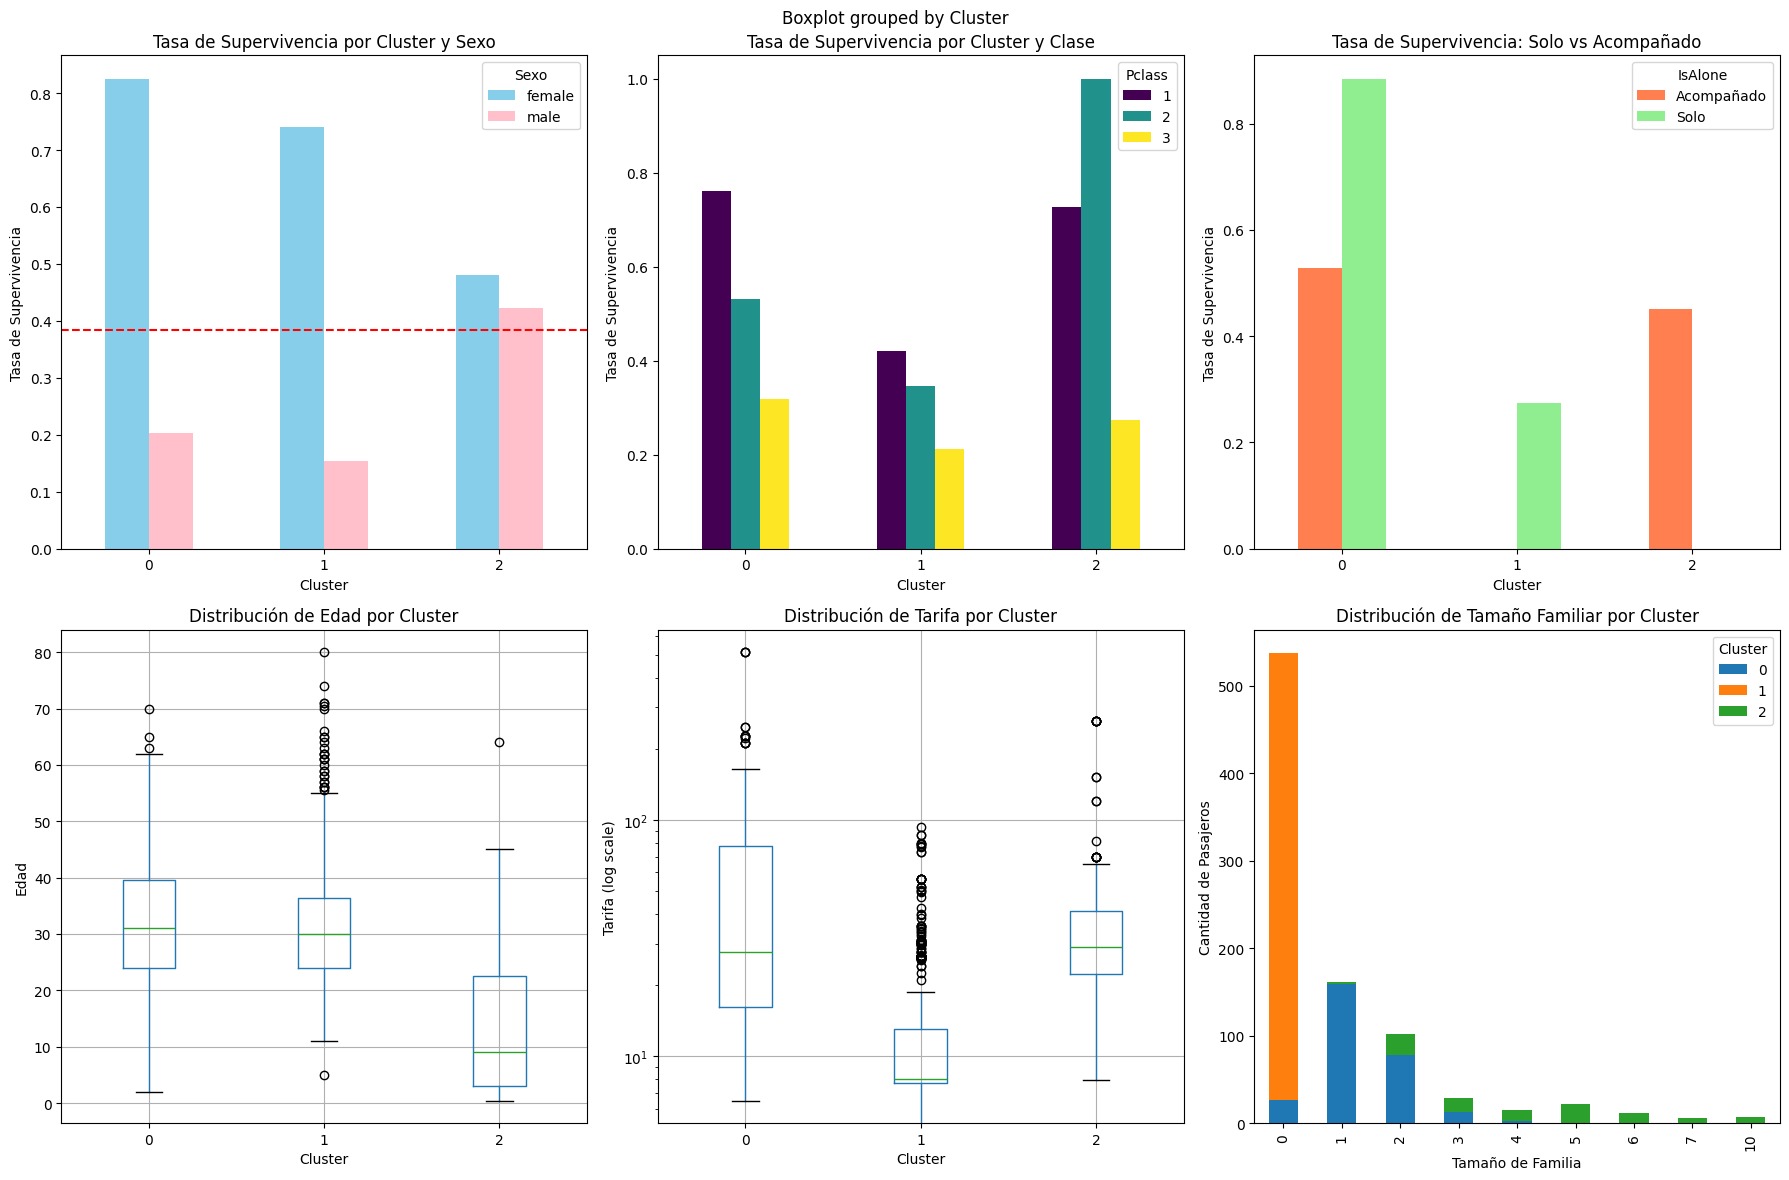

In [15]:
# 1. ANÁLISIS DE SUPERVIVENCIA POR CLUSTER Y CARACTERÍSTICAS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Supervivencia por Cluster', fontsize=16, fontweight='bold')

# 1.1 Supervivencia por Cluster y Sexo
survival_sex = data.groupby(['Cluster', 'Sex'])['Survived'].mean().unstack()
survival_sex.plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'pink'])
axes[0, 0].set_title('Tasa de Supervivencia por Cluster y Sexo')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Tasa de Supervivencia')
axes[0, 0].legend(title='Sexo')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)
axes[0, 0].axhline(y=data['Survived'].mean(), color='red', linestyle='--', label='Promedio General')

# 1.2 Supervivencia por Cluster y Clase
survival_class = data.groupby(['Cluster', 'Pclass'])['Survived'].mean().unstack()
survival_class.plot(kind='bar', ax=axes[0, 1], colormap='viridis')
axes[0, 1].set_title('Tasa de Supervivencia por Cluster y Clase')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Tasa de Supervivencia')
axes[0, 1].legend(title='Pclass')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# 1.3 Supervivencia por Cluster e IsAlone
survival_alone = data.groupby(['Cluster', 'IsAlone'])['Survived'].mean().unstack()
survival_alone.plot(kind='bar', ax=axes[0, 2], color=['coral', 'lightgreen'])
axes[0, 2].set_title('Tasa de Supervivencia: Solo vs Acompañado')
axes[0, 2].set_xlabel('Cluster')
axes[0, 2].set_ylabel('Tasa de Supervivencia')
axes[0, 2].legend(title='IsAlone', labels=['Acompañado', 'Solo'])
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=0)

# 1.4 Distribución de Edad por Cluster
data.boxplot(column='Age', by='Cluster', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Edad por Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Edad')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# 1.5 Distribución de Tarifa por Cluster (escala log)
data.boxplot(column='Fare', by='Cluster', ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Tarifa por Cluster')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Tarifa (log scale)')
axes[1, 1].set_yscale('log')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

# 1.6 Tamaño de Familia por Cluster
family_cluster = data.groupby(['Cluster', 'Family']).size().unstack(fill_value=0)
family_cluster.T.plot(kind='bar', ax=axes[1, 2], stacked=True)
axes[1, 2].set_title('Distribución de Tamaño Familiar por Cluster')
axes[1, 2].set_xlabel('Tamaño de Familia')
axes[1, 2].set_ylabel('Cantidad de Pasajeros')
axes[1, 2].legend(title='Cluster')

plt.tight_layout()
plt.show()

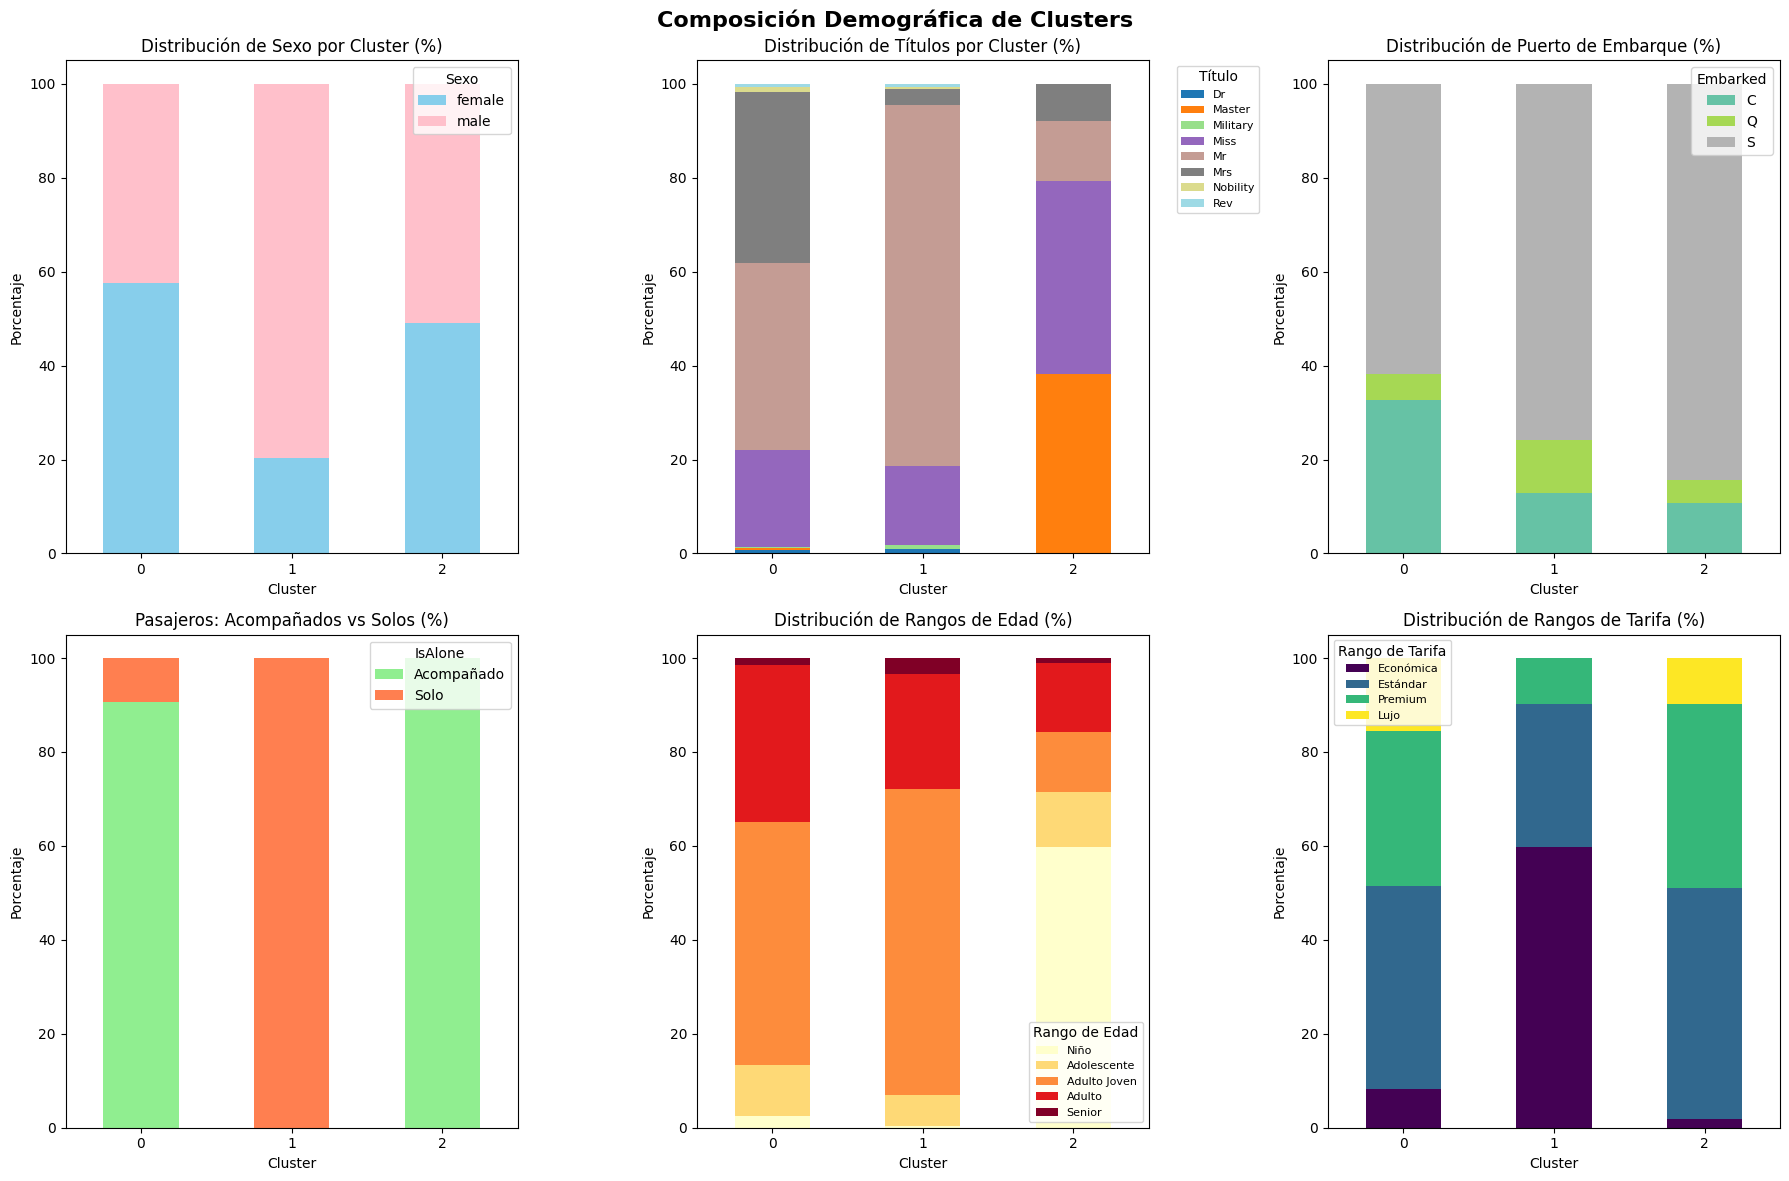

In [16]:
# 2. ANÁLISIS DE COMPOSICIÓN DE CLUSTERS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Composición Demográfica de Clusters', fontsize=16, fontweight='bold')

# 2.1 Distribución de Sexo por Cluster
sex_dist = pd.crosstab(data['Cluster'], data['Sex'], normalize='index') * 100
sex_dist.plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'pink'], stacked=True)
axes[0, 0].set_title('Distribución de Sexo por Cluster (%)')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Porcentaje')
axes[0, 0].legend(title='Sexo')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

# 2.2 Distribución de Título por Cluster
titulo_dist = pd.crosstab(data['Cluster'], data['Titulo'], normalize='index') * 100
titulo_dist.plot(kind='bar', ax=axes[0, 1], stacked=True, colormap='tab20')
axes[0, 1].set_title('Distribución de Títulos por Cluster (%)')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Porcentaje')
axes[0, 1].legend(title='Título', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# 2.3 Distribución de Puerto de Embarque por Cluster
embarked_dist = pd.crosstab(data['Cluster'], data['Embarked'], normalize='index') * 100
embarked_dist.plot(kind='bar', ax=axes[0, 2], stacked=True, colormap='Set2')
axes[0, 2].set_title('Distribución de Puerto de Embarque (%)')
axes[0, 2].set_xlabel('Cluster')
axes[0, 2].set_ylabel('Porcentaje')
axes[0, 2].legend(title='Embarked')
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=0)

# 2.4 Proporción de pasajeros solos vs acompañados
alone_dist = pd.crosstab(data['Cluster'], data['IsAlone'], normalize='index') * 100
alone_dist.plot(kind='bar', ax=axes[1, 0], color=['lightgreen', 'coral'], stacked=True)
axes[1, 0].set_title('Pasajeros: Acompañados vs Solos (%)')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Porcentaje')
axes[1, 0].legend(title='IsAlone', labels=['Acompañado', 'Solo'])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

# 2.5 Rangos de edad por cluster
data['Age_Range'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100], 
                            labels=['Niño', 'Adolescente', 'Adulto Joven', 'Adulto', 'Senior'])
age_range_dist = pd.crosstab(data['Cluster'], data['Age_Range'], normalize='index') * 100
age_range_dist.plot(kind='bar', ax=axes[1, 1], stacked=True, colormap='YlOrRd')
axes[1, 1].set_title('Distribución de Rangos de Edad (%)')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Porcentaje')
axes[1, 1].legend(title='Rango de Edad', fontsize=8)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

# 2.6 Rangos de tarifa por cluster
data['Fare_Range'] = pd.cut(data['Fare'], bins=[0, 10, 30, 100, 1000], 
                             labels=['Económica', 'Estándar', 'Premium', 'Lujo'])
fare_range_dist = pd.crosstab(data['Cluster'], data['Fare_Range'], normalize='index') * 100
fare_range_dist.plot(kind='bar', ax=axes[1, 2], stacked=True, colormap='viridis')
axes[1, 2].set_title('Distribución de Rangos de Tarifa (%)')
axes[1, 2].set_xlabel('Cluster')
axes[1, 2].set_ylabel('Porcentaje')
axes[1, 2].legend(title='Rango de Tarifa', fontsize=8)
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

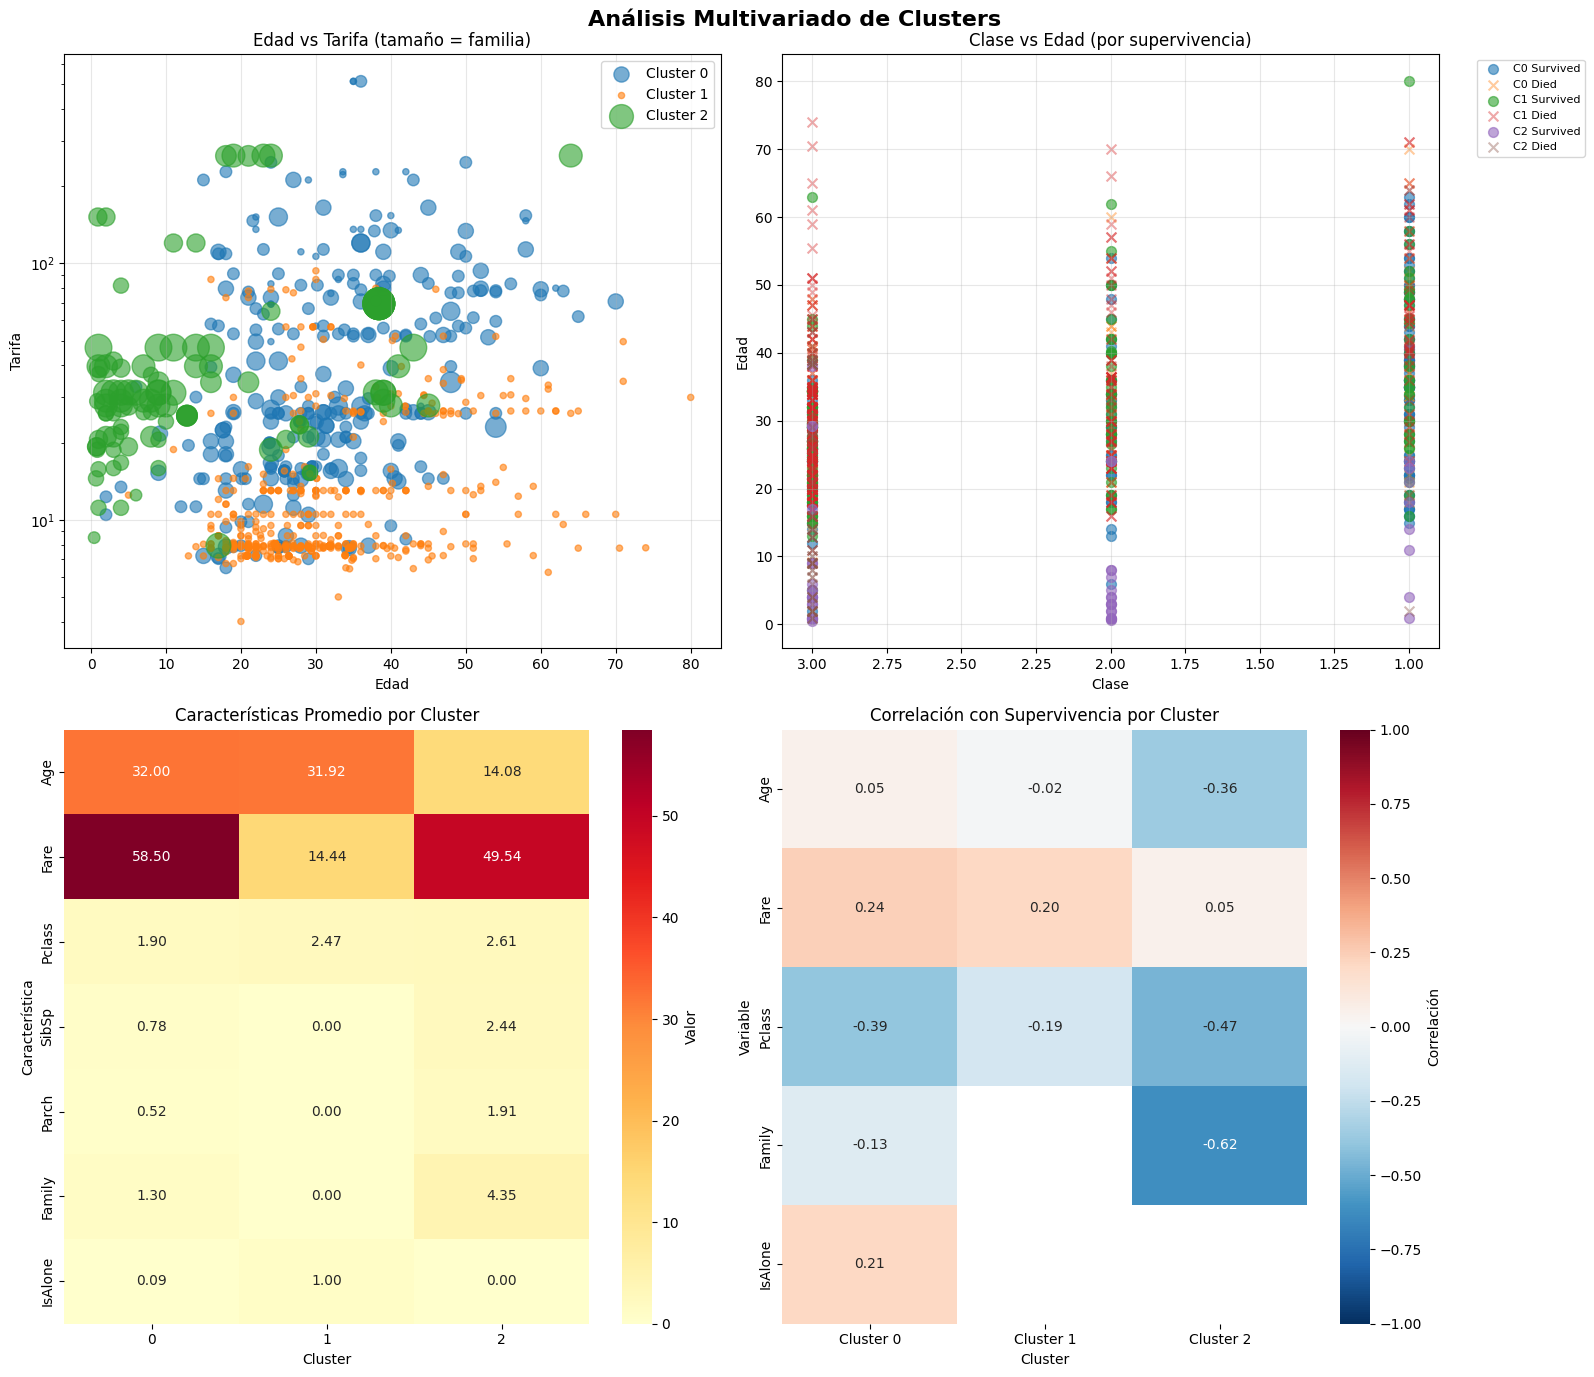

In [17]:
# 3. VISUALIZACIONES AVANZADAS - SCATTER PLOTS Y HEATMAPS
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Análisis Multivariado de Clusters', fontsize=16, fontweight='bold')

# 3.1 Edad vs Tarifa con tamaño por Family
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    axes[0, 0].scatter(cluster_data['Age'], cluster_data['Fare'], 
                      s=cluster_data['Family']*50+20, alpha=0.6, 
                      label=f'Cluster {cluster}')
axes[0, 0].set_xlabel('Edad')
axes[0, 0].set_ylabel('Tarifa')
axes[0, 0].set_title('Edad vs Tarifa (tamaño = familia)')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# 3.2 Pclass vs Age coloreado por supervivencia
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    survived = cluster_data[cluster_data['Survived'] == 1]
    died = cluster_data[cluster_data['Survived'] == 0]
    
    axes[0, 1].scatter(survived['Pclass'], survived['Age'], 
                      marker='o', s=50, alpha=0.6, label=f'C{cluster} Survived')
    axes[0, 1].scatter(died['Pclass'], died['Age'], 
                      marker='x', s=50, alpha=0.4, label=f'C{cluster} Died')
axes[0, 1].set_xlabel('Clase')
axes[0, 1].set_ylabel('Edad')
axes[0, 1].set_title('Clase vs Edad (por supervivencia)')
axes[0, 1].invert_xaxis()
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# 3.3 Heatmap de características promedio por cluster
cluster_features = data.groupby('Cluster')[['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Family', 'IsAlone']].mean()
sns.heatmap(cluster_features.T, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Valor'})
axes[1, 0].set_title('Características Promedio por Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Característica')

# 3.4 Heatmap de correlación entre supervivencia y variables por cluster
correlation_data = []
for cluster in sorted(data['Cluster'].unique()):
    cluster_subset = data[data['Cluster'] == cluster]
    correlations = cluster_subset[['Survived', 'Age', 'Fare', 'Pclass', 'Family', 'IsAlone']].corr()['Survived'].drop('Survived')
    correlation_data.append(correlations)

corr_df = pd.DataFrame(correlation_data, index=[f'Cluster {i}' for i in sorted(data['Cluster'].unique())])
sns.heatmap(corr_df.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1, 1], 
            vmin=-1, vmax=1, cbar_kws={'label': 'Correlación'})
axes[1, 1].set_title('Correlación con Supervivencia por Cluster')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Variable')

plt.tight_layout()
plt.show()

In [18]:
# 4. RESUMEN ESTADÍSTICO DETALLADO POR CLUSTER
print("="*80)
print("PERFIL DETALLADO DE CADA CLUSTER")
print("="*80)

for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster} - {len(cluster_data)} pasajeros ({len(cluster_data)/len(data)*100:.1f}%)")
    print(f"{'='*80}")
    
    print(f"\n📊 SUPERVIVENCIA:")
    print(f"   Tasa de supervivencia: {cluster_data['Survived'].mean()*100:.1f}%")
    print(f"   Sobrevivientes: {cluster_data['Survived'].sum()}")
    print(f"   Fallecidos: {len(cluster_data) - cluster_data['Survived'].sum()}")
    
    print(f"\n👥 DEMOGRAFÍA:")
    print(f"   Edad promedio: {cluster_data['Age'].mean():.1f} años (std: {cluster_data['Age'].std():.1f})")
    print(f"   Rango de edad: {cluster_data['Age'].min():.0f} - {cluster_data['Age'].max():.0f} años")
    print(f"   Sexo - Hombres: {(cluster_data['Sex']=='male').sum()} ({(cluster_data['Sex']=='male').mean()*100:.1f}%)")
    print(f"   Sexo - Mujeres: {(cluster_data['Sex']=='female').sum()} ({(cluster_data['Sex']=='female').mean()*100:.1f}%)")
    
    print(f"\n🎫 CLASE Y TARIFA:")
    print(f"   Clase promedio: {cluster_data['Pclass'].mean():.2f}")
    print(f"   Distribución por clase:")
    for pclass in sorted(cluster_data['Pclass'].unique()):
        count = (cluster_data['Pclass'] == pclass).sum()
        pct = count / len(cluster_data) * 100
        print(f"      Clase {pclass}: {count} ({pct:.1f}%)")
    print(f"   Tarifa promedio: ${cluster_data['Fare'].mean():.2f} (mediana: ${cluster_data['Fare'].median():.2f})")
    print(f"   Rango de tarifa: ${cluster_data['Fare'].min():.2f} - ${cluster_data['Fare'].max():.2f}")
    
    print(f"\n👨‍👩‍👧‍👦 FAMILIA:")
    print(f"   Tamaño promedio de familia: {cluster_data['Family'].mean():.2f}")
    print(f"   Viajan solos: {cluster_data['IsAlone'].sum()} ({cluster_data['IsAlone'].mean()*100:.1f}%)")
    print(f"   Viajan acompañados: {(cluster_data['IsAlone']==0).sum()} ({(cluster_data['IsAlone']==0).mean()*100:.1f}%)")
    print(f"   Promedio SibSp: {cluster_data['SibSp'].mean():.2f}")
    print(f"   Promedio Parch: {cluster_data['Parch'].mean():.2f}")
    
    print(f"\n🏷️ TÍTULOS MÁS COMUNES:")
    top_titulos = cluster_data['Titulo'].value_counts().head(3)
    for titulo, count in top_titulos.items():
        print(f"   {titulo}: {count} ({count/len(cluster_data)*100:.1f}%)")
    
    print(f"\n⚓ PUERTOS DE EMBARQUE:")
    for port in cluster_data['Embarked'].value_counts().index:
        count = (cluster_data['Embarked'] == port).sum()
        pct = count / len(cluster_data) * 100
        print(f"   {port}: {count} ({pct:.1f}%)")

print(f"\n{'='*80}")
print("✓ Análisis de perfiles completado")
print(f"{'='*80}")

PERFIL DETALLADO DE CADA CLUSTER

CLUSTER 0 - 278 pasajeros (31.2%)

📊 SUPERVIVENCIA:
   Tasa de supervivencia: 56.1%
   Sobrevivientes: 156
   Fallecidos: 122

👥 DEMOGRAFÍA:
   Edad promedio: 32.0 años (std: 12.1)
   Rango de edad: 2 - 70 años
   Sexo - Hombres: 118 (42.4%)
   Sexo - Mujeres: 160 (57.6%)

🎫 CLASE Y TARIFA:
   Clase promedio: 1.90
   Distribución por clase:
      Clase 1: 122 (43.9%)
      Clase 2: 62 (22.3%)
      Clase 3: 94 (33.8%)
   Tarifa promedio: $58.50 (mediana: $27.75)
   Rango de tarifa: $6.50 - $512.33

👨‍👩‍👧‍👦 FAMILIA:
   Tamaño promedio de familia: 1.30
   Viajan solos: 26 (9.4%)
   Viajan acompañados: 252 (90.6%)
   Promedio SibSp: 0.78
   Promedio Parch: 0.52

🏷️ TÍTULOS MÁS COMUNES:
   Mr: 111 (39.9%)
   Mrs: 101 (36.3%)
   Miss: 57 (20.5%)

⚓ PUERTOS DE EMBARQUE:
   S: 172 (61.9%)
   C: 91 (32.7%)
   Q: 15 (5.4%)

CLUSTER 1 - 511 pasajeros (57.4%)

📊 SUPERVIVENCIA:
   Tasa de supervivencia: 27.4%
   Sobrevivientes: 140
   Fallecidos: 371

👥 DEMOGRAFÍA

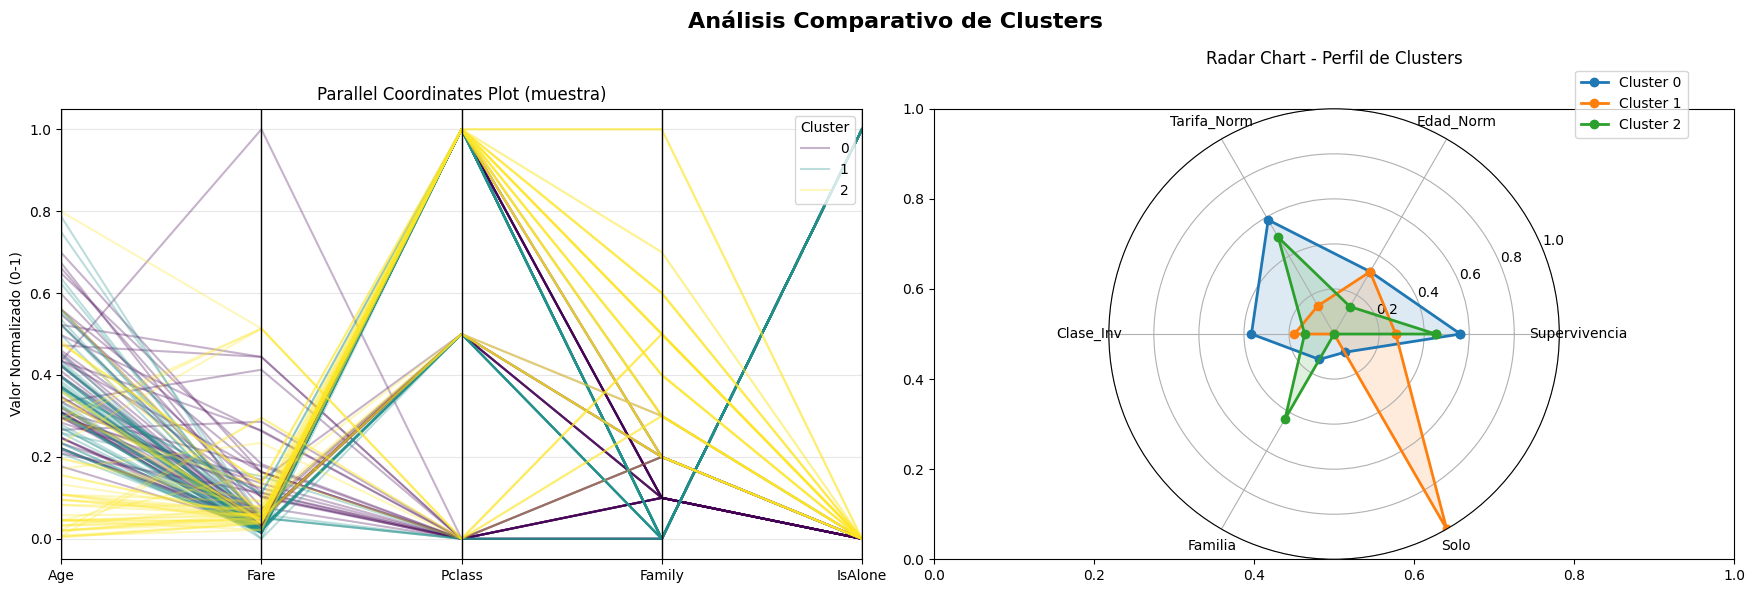

In [19]:
# 5. ANÁLISIS COMPARATIVO - PARALLEL COORDINATES Y RADAR CHARTS
from pandas.plotting import parallel_coordinates

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Análisis Comparativo de Clusters', fontsize=16, fontweight='bold')

# 5.1 Parallel Coordinates Plot
# Preparar datos normalizados para mejor visualización
plot_data = data[['Cluster', 'Age', 'Fare', 'Pclass', 'Family', 'IsAlone']].copy()
# Normalizar entre 0 y 1
for col in ['Age', 'Fare', 'Pclass', 'Family', 'IsAlone']:
    plot_data[col] = (plot_data[col] - plot_data[col].min()) / (plot_data[col].max() - plot_data[col].min())

# Tomar una muestra para mejor visualización
sample_data = plot_data.groupby('Cluster').sample(n=min(50, len(plot_data)//3), random_state=42)
parallel_coordinates(sample_data, 'Cluster', ax=axes[0], colormap='viridis', alpha=0.3)
axes[0].set_title('Parallel Coordinates Plot (muestra)')
axes[0].set_ylabel('Valor Normalizado (0-1)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(title='Cluster', loc='upper right')

# 5.2 Radar Chart de características promedio
from math import pi

# Características para el radar chart
categories = ['Supervivencia', 'Edad_Norm', 'Tarifa_Norm', 'Clase_Inv', 'Familia', 'Solo']
N = len(categories)

# Preparar datos
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(122, polar=True)

for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    values = [
        cluster_data['Survived'].mean(),
        cluster_data['Age'].mean() / 100,  # Normalizar
        min(cluster_data['Fare'].mean() / 100, 1),  # Normalizar y limitar
        1 - (cluster_data['Pclass'].mean() / 3),  # Invertir (1a clase = alto)
        cluster_data['Family'].mean() / 10,  # Normalizar
        cluster_data['IsAlone'].mean()
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Radar Chart - Perfil de Clusters', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

/var/folders/n8/gx2myhcx3wz9n5lc8435j8d80000gn/T/ipykernel_42135/593021713.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = cluster_data.groupby([pd.cut(cluster_data['Age'], bins=10),
/var/folders/n8/gx2myhcx3wz9n5lc8435j8d80000gn/T/ipykernel_42135/593021713.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = cluster_data.groupby([pd.cut(cluster_data['Age'], bins=10),
/var/folders/n8/gx2myhcx3wz9n5lc8435j8d80000gn/T/ipykernel_42135/593021713.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False 

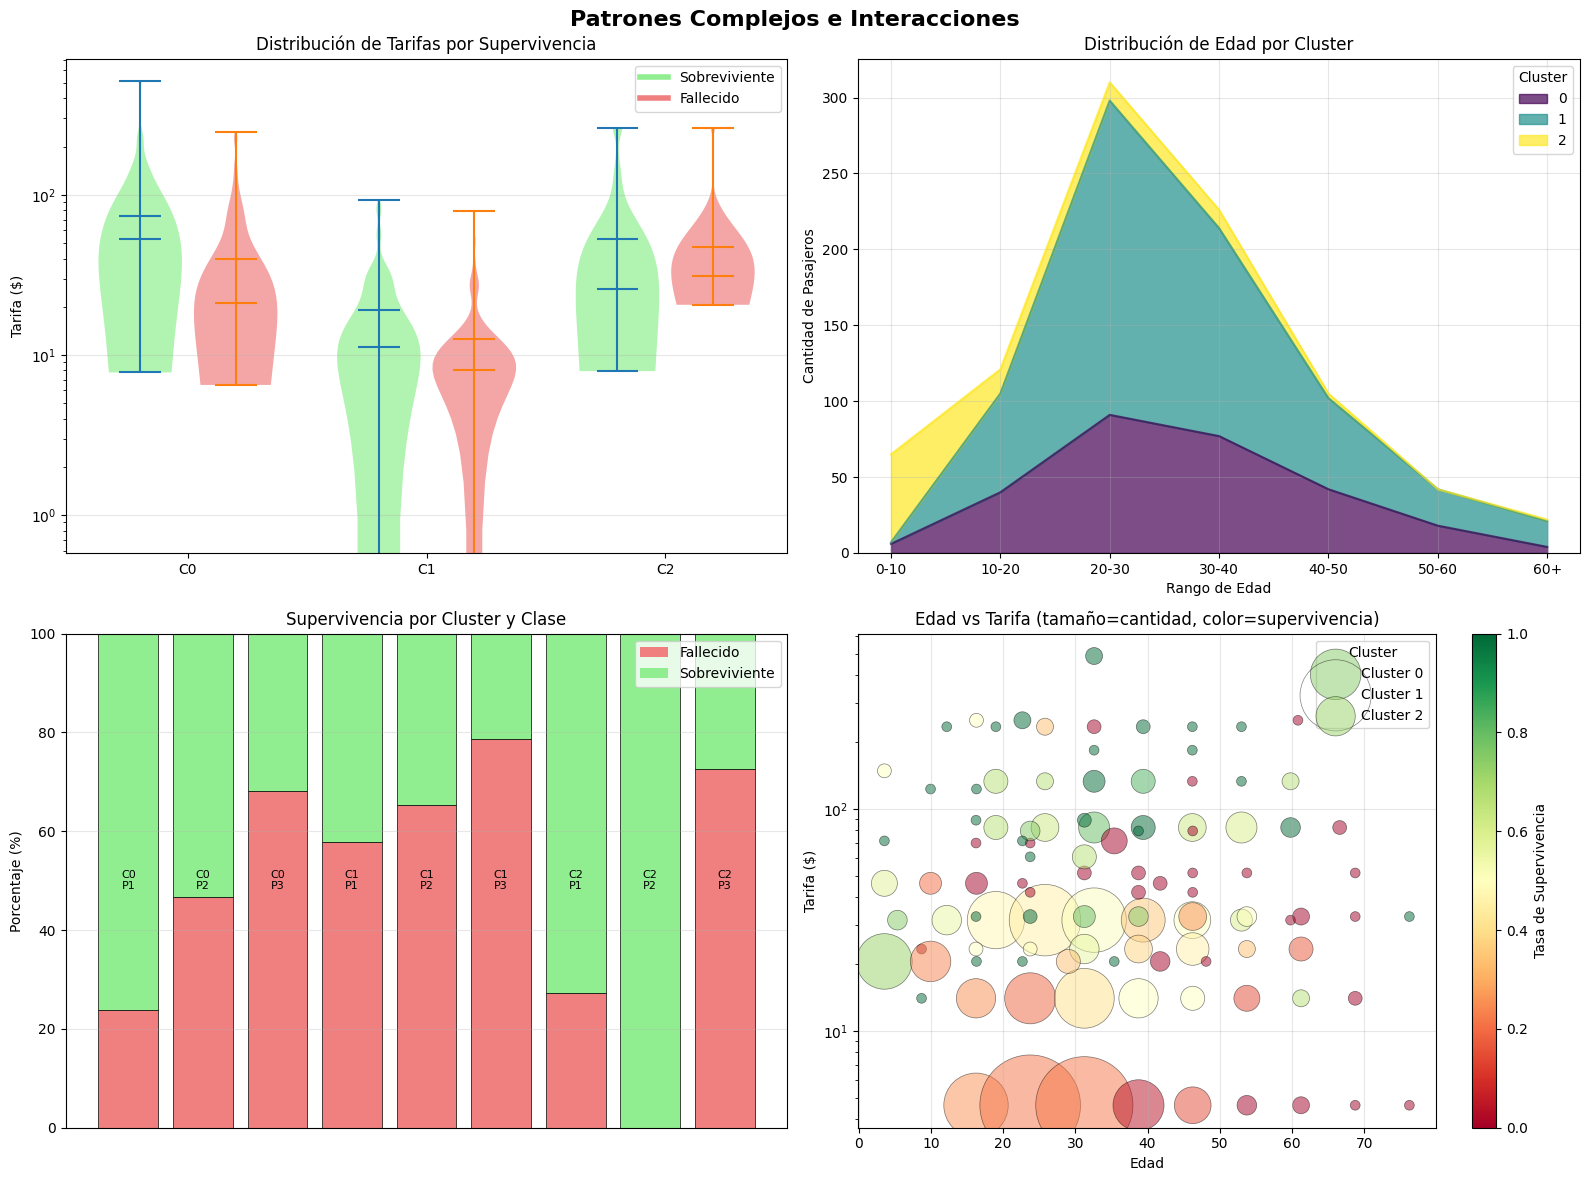

In [20]:
# 6. ANÁLISIS DE INTERACCIONES Y PATRONES COMPLEJOS
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Patrones Complejos e Interacciones', fontsize=16, fontweight='bold')

# 6.1 Violin plot - Distribución de tarifas por cluster y supervivencia
survival_labels = {0: 'Fallecido', 1: 'Sobreviviente'}
data['Survived_Label'] = data['Survived'].map(survival_labels)

parts = axes[0, 0].violinplot(
    [data[(data['Cluster']==c) & (data['Survived']==1)]['Fare'].dropna() for c in sorted(data['Cluster'].unique())],
    positions=np.arange(len(data['Cluster'].unique()))*2,
    widths=0.7,
    showmeans=True,
    showmedians=True
)
for pc in parts['bodies']:
    pc.set_facecolor('lightgreen')
    pc.set_alpha(0.7)

parts = axes[0, 0].violinplot(
    [data[(data['Cluster']==c) & (data['Survived']==0)]['Fare'].dropna() for c in sorted(data['Cluster'].unique())],
    positions=np.arange(len(data['Cluster'].unique()))*2+0.8,
    widths=0.7,
    showmeans=True,
    showmedians=True
)
for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)

axes[0, 0].set_xticks(np.arange(len(data['Cluster'].unique()))*2+0.4)
axes[0, 0].set_xticklabels([f'C{i}' for i in sorted(data['Cluster'].unique())])
axes[0, 0].set_ylabel('Tarifa ($)')
axes[0, 0].set_title('Distribución de Tarifas por Supervivencia')
axes[0, 0].set_yscale('log')
axes[0, 0].legend([plt.Line2D([0], [0], color='lightgreen', lw=4), 
                   plt.Line2D([0], [0], color='lightcoral', lw=4)],
                  ['Sobreviviente', 'Fallecido'])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 6.2 Stacked area chart - Evolución de edad
age_bins = [0, 10, 20, 30, 40, 50, 60, 100]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
data['Age_Bin'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)

age_cluster_dist = pd.crosstab(data['Age_Bin'], data['Cluster'])
age_cluster_dist.plot(kind='area', stacked=True, ax=axes[0, 1], alpha=0.7, colormap='viridis')
axes[0, 1].set_title('Distribución de Edad por Cluster')
axes[0, 1].set_xlabel('Rango de Edad')
axes[0, 1].set_ylabel('Cantidad de Pasajeros')
axes[0, 1].legend(title='Cluster')
axes[0, 1].grid(True, alpha=0.3)

# 6.3 Mosaic plot simulado - Supervivencia por Clase y Cluster
from itertools import product

mosaic_data = data.groupby(['Cluster', 'Pclass', 'Survived']).size().reset_index(name='count')
pivot = mosaic_data.pivot_table(values='count', index=['Cluster', 'Pclass'], columns='Survived', fill_value=0)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

x_pos = 0
colors_surv = {0: 'lightcoral', 1: 'lightgreen'}
cluster_positions = {}

for cluster in sorted(data['Cluster'].unique()):
    for pclass in sorted(data['Pclass'].unique()):
        if (cluster, pclass) in pivot_pct.index:
            height_died = pivot_pct.loc[(cluster, pclass), 0]
            height_survived = pivot_pct.loc[(cluster, pclass), 1]
            
            # Died
            axes[1, 0].bar(x_pos, height_died, width=0.8, color='lightcoral', edgecolor='black', linewidth=0.5)
            # Survived
            axes[1, 0].bar(x_pos, height_survived, width=0.8, bottom=height_died, 
                          color='lightgreen', edgecolor='black', linewidth=0.5)
            
            # Etiquetar
            axes[1, 0].text(x_pos, 50, f'C{cluster}\nP{pclass}', ha='center', va='center', fontsize=8)
            
            x_pos += 1

axes[1, 0].set_ylabel('Porcentaje (%)')
axes[1, 0].set_title('Supervivencia por Cluster y Clase')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].legend([plt.Rectangle((0,0),1,1, fc='lightcoral'), 
                   plt.Rectangle((0,0),1,1, fc='lightgreen')],
                  ['Fallecido', 'Sobreviviente'])
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks([])

# 6.4 Bubble chart - Edad vs Tarifa con múltiples dimensiones
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    # Agrupar para evitar sobrecarga
    grouped = cluster_data.groupby([pd.cut(cluster_data['Age'], bins=10), 
                                    pd.cut(cluster_data['Fare'], bins=10)]).agg({
        'PassengerId': 'count',
        'Survived': 'mean'
    }).reset_index()
    
    # Obtener valores centrales de los bins
    grouped['Age_mid'] = grouped['Age'].apply(lambda x: x.mid)
    grouped['Fare_mid'] = grouped['Fare'].apply(lambda x: x.mid)
    
    axes[1, 1].scatter(grouped['Age_mid'], grouped['Fare_mid'], 
                      s=grouped['PassengerId']*50, 
                      c=grouped['Survived'], 
                      alpha=0.5, 
                      cmap='RdYlGn',
                      edgecolors='black',
                      linewidth=0.5,
                      vmin=0, vmax=1,
                      label=f'Cluster {cluster}')

axes[1, 1].set_xlabel('Edad')
axes[1, 1].set_ylabel('Tarifa ($)')
axes[1, 1].set_title('Edad vs Tarifa (tamaño=cantidad, color=supervivencia)')
axes[1, 1].set_yscale('log')
axes[1, 1].legend(title='Cluster', loc='upper right')
axes[1, 1].grid(True, alpha=0.3)

# Agregar colorbar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1, 1])
cbar.set_label('Tasa de Supervivencia')

plt.tight_layout()
plt.show()

## Conclusiones y Insights Clave

### Instrucciones para interpretar los gráficos:

1. **Análisis de Supervivencia por Cluster**: Identifica qué clusters tienen mayor tasa de supervivencia y qué características demográficas los distinguen (sexo, clase, si viajaban solos)

2. **Composición Demográfica**: Observa la composición de cada cluster en términos de edad, sexo, títulos y puerto de embarque para entender el perfil de cada grupo

3. **Visualizaciones Avanzadas**: 
   - Los scatter plots muestran relaciones multivariadas
   - Los heatmaps revelan correlaciones y características promedio
   - Busca patrones de clusters con alta/baja supervivencia

4. **Resumen Estadístico**: Lee el perfil detallado de cada cluster para obtener una descripción completa

5. **Parallel Coordinates & Radar Charts**: Compara visualmente todos los clusters en múltiples dimensiones simultáneamente

6. **Patrones Complejos**: Los violin plots y bubble charts revelan interacciones complejas entre variables como edad, tarifa y supervivencia

### Preguntas clave a responder:
- ¿Qué cluster tiene la mayor tasa de supervivencia y por qué?
- ¿Existen patrones claros que separen a los sobrevivientes de los fallecidos dentro de cada cluster?
- ¿Cómo influye el tamaño de la familia en la supervivencia según el cluster?
- ¿Hay clusters que representan grupos vulnerables o privilegiados?